In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # prompt: how to download file from https://drive.google.com/file/d/1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ/view?usp=drive_link and extract in  /content/drive/MyDrive/HW2

# # Install gdown if not already installed
# !pip install gdown

# # Create the destination directory if it doesn't exist
# !mkdir -p /content/drive/MyDrive/HW2

# # Download the file using gdown
# !gdown https://drive.google.com/uc?id=1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ -O /content/drive/MyDrive/HW2/downloaded_file.zip

# # Change to the destination directory
# %cd /content/drive/MyDrive/HW2

# # Extract the contents of the zip file
# !unzip downloaded_file.zip

# # Remove the zip file after extraction (optional)
# !rm downloaded_file.zip

# # List the contents to see the extracted files
# !ls -l

# print("File downloaded and extracted successfully in /content/drive/MyDrive/HW2!")

In [ ]:
!cd '/content/drive/My Drive/HW2' # if not first time

## Set seed

In [ ]:
import random, os
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


# Train, Test, Validation Datasets

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Basic transform (resize + tensor conversion)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Paths
train_dir = "/content/drive/MyDrive/HW2/Data/train"
valid_dir = "/content/drive/MyDrive/HW2/Data/valid"
test_dir = "/content/drive/MyDrive/HW2/Data/test"

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=base_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Datasets loaded:\n- Train: {len(train_dataset)}\n- Valid: {len(valid_dataset)}\n- Test: {len(test_dataset)}")
print(f"Class names: {train_dataset.classes}")


Datasets loaded:
- Train: 613
- Valid: 72
- Test: 315
Class names: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


# Create the CNN model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCancerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCancerCNN, self).__init__()

        self.features = nn.Sequential(
            # Conv + Pool 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: 32 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32 x 112 x 112

            # Conv + Pool 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64 x 56 x 56

            # Conv + Pool 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: 128 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 128 x 28 x 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Training

In [ ]:
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc += calculate_accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += calculate_accuracy(outputs, labels) * inputs.size(0)

    val_loss /= len(dataloader.dataset)
    val_acc /= len(dataloader.dataset)
    return val_loss, val_acc


In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, valid_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        print(f"Epoch {epoch}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Valid Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(valid_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/15
  Train Loss: 2.2434, Accuracy: 0.2365
  Valid Loss: 1.3626, Accuracy: 0.2361
Epoch 2/15
  Train Loss: 1.2599, Accuracy: 0.3817
  Valid Loss: 1.1642, Accuracy: 0.4583
Epoch 3/15
  Train Loss: 1.0406, Accuracy: 0.5188
  Valid Loss: 1.0216, Accuracy: 0.5000
Epoch 4/15
  Train Loss: 0.9072, Accuracy: 0.5775
  Valid Loss: 0.9186, Accuracy: 0.6111
Epoch 5/15
  Train Loss: 0.7947, Accuracy: 0.6525
  Valid Loss: 0.8316, Accuracy: 0.7639
Epoch 6/15
  Train Loss: 0.6592, Accuracy: 0.7455
  Valid Loss: 0.8608, Accuracy: 0.6806
Epoch 7/15
  Train Loss: 0.5471, Accuracy: 0.7781
  Valid Loss: 0.8149, Accuracy: 0.6667
Epoch 8/15
  Train Loss: 0.4151, Accuracy: 0.8271
  Valid Loss: 0.8905, Accuracy: 0.6667
Epoch 9/15
  Train Loss: 0.3454, Accuracy: 0.8744
  Valid Loss: 0.8272, Accuracy: 0.6806
Epoch 10/15
  Train Loss: 0.2584, Accuracy: 0.9184
  Valid Loss: 0.7148, Accuracy: 0.7222
Epoch 11/15
  Train Loss: 0.2208, Accuracy: 0.9347
  Valid Loss: 1.1361, Accuracy: 0.6389
Epoch 12/15
  Train

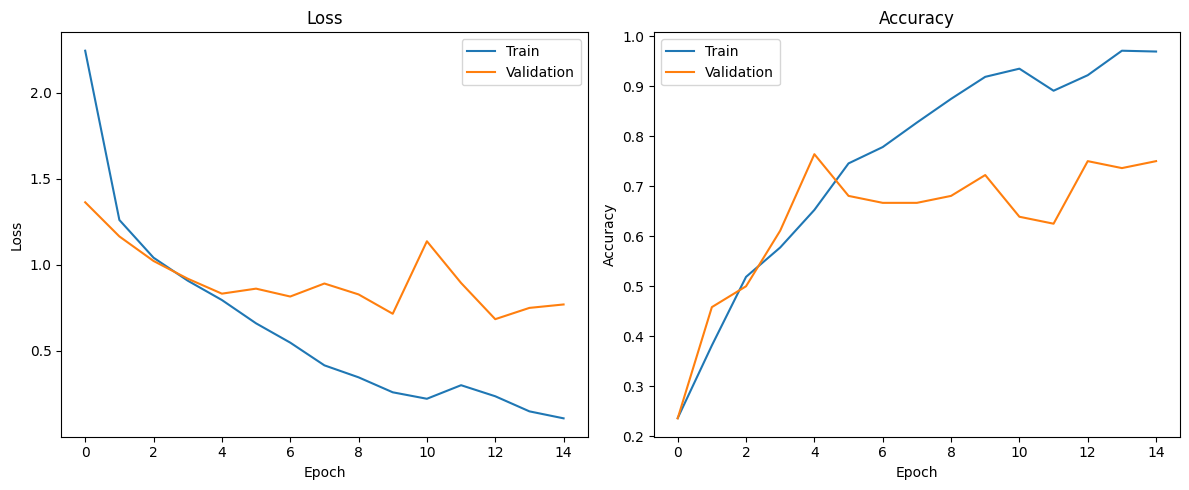

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simple_model = SimpleCancerCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)

train(simple_model, train_loader, valid_loader, criterion, optimizer, device, epochs=15)


همانطور که دیده می‌شود، فرایند یادگیری بعد از ایپاک دوازدهم به سمت اورفیت شدن می‌رود.

# Data Augmentation

In [ ]:
from torchvision import transforms
from torchvision.transforms import AutoAugmentPolicy


# I selected these rwo augmentations because others made training so noisy
aug_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomResizedCrop((224, 224)),
    ]),
    transforms.Resize((224, 224)),  # Ensure size consistency
    transforms.ToTensor(),
])

# Load original dataset (no augmentations)
train_orig_dataset = datasets.ImageFolder(train_dir, transform=base_transform)

# Load augmented dataset (applies RandomFlip or RandomCrop)
train_aug_only_dataset = datasets.ImageFolder(train_dir, transform=aug_transform)

# Add them up
train_aug_dataset = torch.utils.data.ConcatDataset([train_orig_dataset, train_aug_only_dataset])

# Create DataLoader
train_aug_loader = DataLoader(train_aug_dataset, batch_size=64, shuffle=True)



Epoch 1/30
  Train Loss: 1.4247, Accuracy: 0.4086
  Valid Loss: 1.0331, Accuracy: 0.5139
Epoch 2/30
  Train Loss: 0.9103, Accuracy: 0.5612
  Valid Loss: 0.9619, Accuracy: 0.6389
Epoch 3/30
  Train Loss: 0.6812, Accuracy: 0.7080
  Valid Loss: 0.7864, Accuracy: 0.6389
Epoch 4/30
  Train Loss: 0.5310, Accuracy: 0.7798
  Valid Loss: 0.6463, Accuracy: 0.7222
Epoch 5/30
  Train Loss: 0.4332, Accuracy: 0.8320
  Valid Loss: 1.3013, Accuracy: 0.5556
Epoch 6/30
  Train Loss: 0.4367, Accuracy: 0.8287
  Valid Loss: 0.6838, Accuracy: 0.7361
Epoch 7/30
  Train Loss: 0.4003, Accuracy: 0.8491
  Valid Loss: 0.6077, Accuracy: 0.7500
Epoch 8/30
  Train Loss: 0.3108, Accuracy: 0.8777
  Valid Loss: 0.6394, Accuracy: 0.7361
Epoch 9/30
  Train Loss: 0.3069, Accuracy: 0.8801
  Valid Loss: 0.6168, Accuracy: 0.7083
Epoch 10/30
  Train Loss: 0.2577, Accuracy: 0.9078
  Valid Loss: 0.5726, Accuracy: 0.7639
Epoch 11/30
  Train Loss: 0.2626, Accuracy: 0.8923
  Valid Loss: 0.6937, Accuracy: 0.7361
Epoch 12/30
  Train

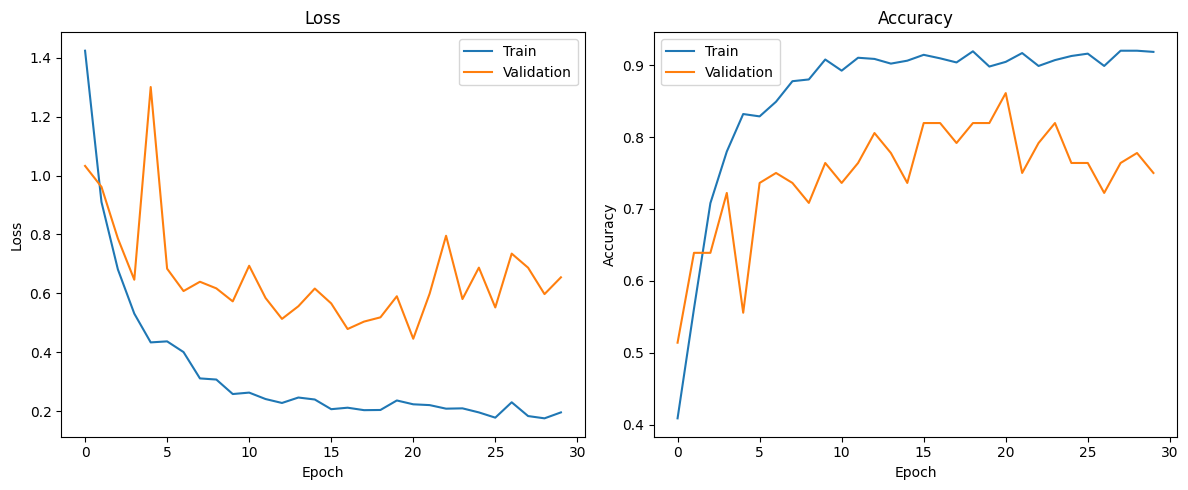

In [ ]:
# New model instance
model_aug = SimpleCancerCNN(num_classes=4).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train(model_aug, train_aug_loader, valid_loader, criterion, optimizer, device, epochs=30)


بعد از ایپاک ۲۱ اورفیتینگ رخ داده است. بهترین دقت در ولیدیشن ۸۶ درصد است

# Add dropout, regularization, normalization, weight decay, adaptive learning rate

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CancerCNN(nn.Module):
    def __init__(self, num_classes=4,dropout=0.5):
        super(CancerCNN, self).__init__()

        self.features = nn.Sequential(
            # Conv + Pool 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: 32 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32 x 112 x 112

            # Conv + Pool 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64 x 56 x 56

            # Conv + Pool 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: 128 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 128 x 28 x 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_acc += calculate_accuracy(outputs, labels) * images.size(0)

    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_acc += calculate_accuracy(outputs, labels) * images.size(0)

    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)


In [ ]:
import torch
import copy

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30, patience=5):
    best_val_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Valid Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print("   Best model updated!")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("   Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)

    # Plotting loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


In [ ]:
aug_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomResizedCrop((224, 224)),
    ]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # use normalization
])
# Load original dataset (no augmentations)
train_orig_dataset = datasets.ImageFolder(train_dir, transform=base_transform)

# Load augmented dataset (applies RandomFlip or RandomCrop)
train_aug_only_dataset = datasets.ImageFolder(train_dir, transform=aug_transform)

train_aug_dataset_nor = torch.utils.data.ConcatDataset([train_orig_dataset, train_aug_only_dataset])

# Create DataLoader
train_aug_loader_nor = DataLoader(train_aug_dataset_nor, batch_size=128, shuffle=True)

# Datasets
valid_dataset_nor = datasets.ImageFolder(valid_dir, transform=base_transform)
test_dataset_nor = datasets.ImageFolder(test_dir, transform=base_transform)

# DataLoaders
valid_loader_nor = DataLoader(valid_dataset_nor, batch_size=128, shuffle=False)
test_loader_nor = DataLoader(test_dataset_nor, batch_size=128, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.3848, Accuracy: 0.3940
  Valid Loss: 1.1701, Accuracy: 0.3889
   Best model updated!
Epoch 2/30
  Train Loss: 1.0753, Accuracy: 0.5016
  Valid Loss: 1.0328, Accuracy: 0.5139
   Best model updated!
Epoch 3/30
  Train Loss: 0.9731, Accuracy: 0.5498
  Valid Loss: 1.0269, Accuracy: 0.4722
Epoch 4/30
  Train Loss: 0.8768, Accuracy: 0.5897
  Valid Loss: 0.9791, Accuracy: 0.5278
   Best model updated!
Epoch 5/30
  Train Loss: 0.8263, Accuracy: 0.6166
  Valid Loss: 0.9803, Accuracy: 0.6250
   Best model updated!
Epoch 6/30
  Train Loss: 0.7914, Accuracy: 0.6387
  Valid Loss: 1.0287, Accuracy: 0.5972
Epoch 7/30
  Train Loss: 0.7270, Accuracy: 0.6949
  Valid Loss: 1.0085, Accuracy: 0.6389
   Best model updated!
Epoch 8/30
  Train Loss: 0.6311, Accuracy: 0.7219
  Valid Loss: 0.8807, Accuracy: 0.6667
   Best model updated!
Epoch 9/30
  Train Loss: 0.5764, Accuracy: 0.7749
  Valid Loss: 0.7624, Accuracy: 0.6389
Epoch 10/30
  Train Loss: 0.5113, Accuracy: 0.7928
  Valid Lo

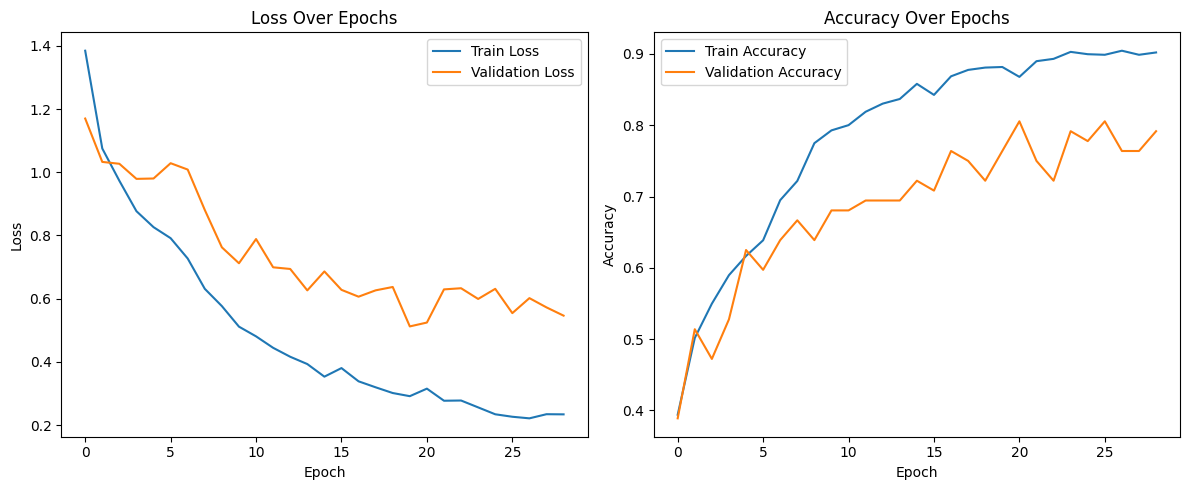

In [ ]:
model = CancerCNN(num_classes=4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train
model = train(model, train_aug_loader_nor, valid_loader_nor, criterion, optimizer, scheduler, device, epochs=30, patience=8)


## Test the models

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_acc += calculate_accuracy(outputs, labels) * images.size(0)

    avg_loss = total_loss / len(test_loader.dataset)
    avg_acc = total_acc / len(test_loader.dataset)

    return avg_loss, avg_acc


In [ ]:
test_loss, test_acc = test_model(model, test_loader_nor, criterion, device)
print(f"Test model(aug+regularization + early stopping ...) - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

test_loss_aug, test_acc_aug = test_model(model_aug, test_loader, criterion, device)
print(f"Test (aug) - Loss: {test_loss_aug:.4f}, Accuracy: {test_acc_aug:.4f}")

test_loss, test_acc = test_model(simple_model, test_loader, criterion, device)
print(f"Test model simple - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Test model(aug+regularization + early stopping ...) - Loss: 1.1922, Accuracy: 0.5731
Test (aug) - Loss: 1.8254, Accuracy: 0.4890
Test model simple - Loss: 2.8880, Accuracy: 0.4332


# Hyper-parameter tuning

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xodempfire (xodempfire-isfahan-higher-education-and-research-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def sweep_train():
    wandb.init()
    config = wandb.config

    model = CancerCNN(num_classes=4,dropout = config.dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


    best_acc = 0
    for epoch in range(15):
        train_loss, train_acc = train_one_epoch(model, train_aug_loader_nor, optimizer, criterion, device)
        val_loss, val_acc = validate(model, valid_loader_nor, criterion, device)
        scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        if val_acc > best_acc:
            best_acc = val_acc

    test_loss, test_acc = test_model(model, test_loader_nor, criterion, device)
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

    wandb.run.summary["best_val_accuracy"] = best_acc
    wandb.run.summary["final_test_accuracy"] = test_acc

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'lr': {'values': [1e-3, 5e-4]},
        'dropout': {'values': [0.3, 0.5]},
    }
}
sweep_id = wandb.sweep(sweep_config, project="cancer-cnn")
wandb.agent(sweep_id, function=sweep_train, count=10)


Create sweep with ID: ppng41tf
Sweep URL: https://wandb.ai/xodempfire-isfahan-higher-education-and-research-institute/cancer-cnn/sweeps/ppng41tf


wandb: Agent Starting Run: 73gzlp7w with config:
wandb: 	dropout: 0.3
wandb: 	lr: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▄▅▆▇▇▇█████
train_loss,█▆▅▅▄▄▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▃▃▅▅▆▆▇▇▇▇▇█▇
val_loss,█▇██▅▄▄▅▂▂▂▂▁▁▂
best_val_accuracy,0.75
epoch,14
final_test_accuracy,0.49841
test_accuracy,0.49841


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsz5pfax with config:
wandb: 	dropout: 0.3
wandb: 	lr: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▅▅▅▆▆▇▇▇███
train_loss,█▄▄▃▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▂▁▂▂▅▅▅▅▅▇▇▆██▇
val_loss,█▆▆▇▅▅▄▃▃▂▁▂▁▁▃
best_val_accuracy,0.76389
epoch,14
final_test_accuracy,0.54921
test_accuracy,0.54921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fl0pbvw with config:
wandb: 	dropout: 0.5
wandb: 	lr: 0.0005


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▅▆▆▆▇▇▇████
train_loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▄▆▆▅▅▆▇█▇█▇
val_loss,█▆▆▅▆▅▃▃▃▃▁▁▂▁▁
best_val_accuracy,0.76389
epoch,14
final_test_accuracy,0.49206
test_accuracy,0.49206


wandb: Agent Starting Run: 7lfm2coj with config:
wandb: 	dropout: 0.3
wandb: 	lr: 0.0005


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▆▇▇▇██████
train_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▂▃▆▆▆▆▆▇▇▇█▇█
val_loss,█▆▆▅▆▃▃▂▃▃▃▁▁▂▂
best_val_accuracy,0.75
epoch,14
final_test_accuracy,0.50794
test_accuracy,0.50794


wandb: Agent Starting Run: i8f3924b with config:
wandb: 	dropout: 0.3
wandb: 	lr: 0.0005


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▆▇▇▇▇█████
train_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▄▆▅▅▅▇▇██▆▇█
val_loss,█▆▆▆▅▅▃█▂▂▄▂▅▁▃
best_val_accuracy,0.76389
epoch,14
final_test_accuracy,0.53016
test_accuracy,0.53016


wandb: Agent Starting Run: 34cgqicu with config:
wandb: 	dropout: 0.5
wandb: 	lr: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▅▆▆▆▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▂▁▂▃▃█▃▇▆█▇▇▇▇
val_loss,█▃▅▄▅▃▂▂▁▂▂▁▁▁▁
best_val_accuracy,0.625
epoch,14
final_test_accuracy,0.50476
test_accuracy,0.50476


wandb: Agent Starting Run: scb8sxbo with config:
wandb: 	dropout: 0.5
wandb: 	lr: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▃▄▅▅▆▆▇▇▇████
train_loss,█▅▅▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▅▆▇▆▇▇▇▇██
val_loss,█▆▆▅▅▆▃▂▃▂▂▁▁▁▂
best_val_accuracy,0.75
epoch,14
final_test_accuracy,0.49524
test_accuracy,0.49524


wandb: Agent Starting Run: bsxjfyy9 with config:
wandb: 	dropout: 0.5
wandb: 	lr: 0.0005


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▄▅▆▆▇▇▇████
train_loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁▁
val_accuracy,▁▁▁▄▆▇▇▆▆▇▇█▆▇▇
val_loss,▇█▇▆▅▄▃▃▄▃▂▁▂▁▁
best_val_accuracy,0.76389
epoch,14
final_test_accuracy,0.51746
test_accuracy,0.51746


wandb: Agent Starting Run: uasohh6v with config:
wandb: 	dropout: 0.3
wandb: 	lr: 0.0005


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▅▅▆▇▇▇█████
train_loss,█▆▅▄▄▄▃▂▂▂▁▁▁▁▁
val_accuracy,▁▁▂▂▄▆▅▆▇▆▆█▇▇█
val_loss,█▆▅▆▅▅▄▄▂▂▃▂▁▂▃
best_val_accuracy,0.75
epoch,14
final_test_accuracy,0.48254
test_accuracy,0.48254


wandb: Agent Starting Run: z0jxjbst with config:
wandb: 	dropout: 0.5
wandb: 	lr: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▄▅▆▆▇▇▇█▇███
train_loss,█▆▅▅▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▁▂▆▅▄▆▇████▇▇█
val_loss,██▇▆▅▅▄▂▂▁▁▂▂▃▁
best_val_accuracy,0.73611
epoch,14
final_test_accuracy,0.51746
test_accuracy,0.51746


dropout: 0.5
lr: 0.0005
با این تنظیمات بهترین دقت بدست می‌آید

# Use ResNet 34

In [ ]:
from torchvision import transforms, datasets, models
def build_resnet34_model(num_classes=4,dropout=0.5):
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False  # Freeze all feature layers

    # Replace the classifier
    model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,num_classes)
    )
    return model


In [ ]:
def train_model(model, train_loader, val_loader, test_loader, config, device):
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_model = None
    best_val_acc = 0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(config['epochs']):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{config['epochs']}\n  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}\n  Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model)
    test_loss, test_acc = test_model(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 1/30
  Train Loss: 1.2832, Accuracy: 0.4307
  Val Loss: 1.1627, Accuracy: 0.4861
Epoch 2/30
  Train Loss: 1.0516, Accuracy: 0.5375
  Val Loss: 1.0252, Accuracy: 0.4167
Epoch 3/30
  Train Loss: 0.9045, Accuracy: 0.5881
  Val Loss: 0.9601, Accuracy: 0.5417
Epoch 4/30
  Train Loss: 0.8332, Accuracy: 0.6117
  Val Loss: 0.9902, Accuracy: 0.5556
Epoch 5/30
  Train Loss: 0.7750, Accuracy: 0.6395
  Val Loss: 0.9560, Accuracy: 0.4583
Epoch 6/30
  Train Loss: 0.7334, Accuracy: 0.6786
  Val Loss: 0.9301, Accuracy: 0.4861
Epoch 7/30
  Train Loss: 0.6996, Accuracy: 0.6982
  Val Loss: 0.8402, Accuracy: 0.6250
Epoch 8/30
  Train Loss: 0.6190, Accuracy: 0.7423
  Val Loss: 0.7776, Accuracy: 0.6250
Epoch 9/30
  Train Loss: 0.5726, Accuracy: 0.7724
  Val Loss: 0.7551, Accuracy: 0.6111
Epoch 10/30
  Train Loss: 0.5684, Accuracy: 0.7798
  Val Loss: 0.7087, Accuracy: 0.7083
Epoch 11/30
  Train Loss: 0.5719, Accuracy: 0.7569
  Val Loss: 0.7107, Accuracy: 0.6944
Epoch 12/30
  Train Loss: 0.5132, Accurac

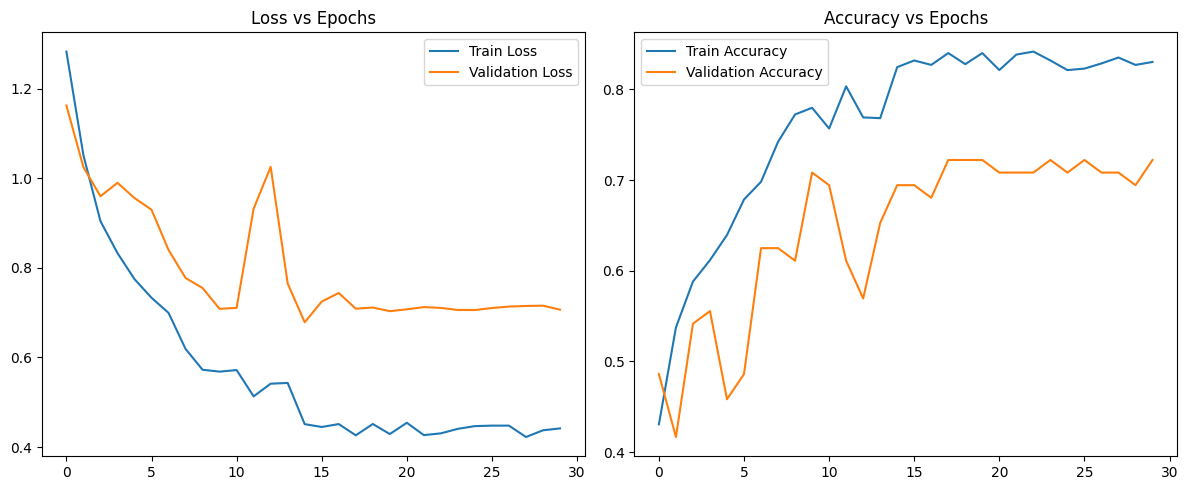

In [ ]:
config = {
    'lr': 0.0005,
    'dropout': 0.5,
    'epochs': 30,
    'weight_decay': 0.0005
}

model = build_resnet34_model(num_classes=4, dropout=config['dropout'])
model.to(device)
trained_model = train_model(model, train_aug_loader_nor , valid_loader_nor, test_loader_nor, config, device)

دقت نهایی بر روی تست ۶۰ درصد است